<a href="https://colab.research.google.com/github/joelodero/Tanzania-An.-funestus-population-genetics/blob/master/TZ_Funestus_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Tanzania population genetics analysis notebook
#Author: Joel Odero
#Updated: Dec 2024

In [1]:
#installing malariagen_data package
%pip install -q --no-warn-conflicts malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 75.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.4/180.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.4/765.4 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.4/24.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6

In [2]:
import malariagen_data
import xarray as xr
import google.auth
import os
import re
import warnings
from typing import List
import plotly.express as px
import ipyleaflet
import bokeh
import allel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
#from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy
import seaborn as sns
import scipy
import matplotlib as mpl


In [3]:
try:
    from google.colab import drive
    drive.mount("drive")
except ImportError:
    pass

Mounted at drive


In [4]:
af1 = malariagen_data.Af1(pre=True)
results_dir = 'drive/MyDrive/tz_funestus_analysis'
af1



<MalariaGEN Af1 API client>
Storage URL             : gs://vo_afun_release_master_us_central1/
Data releases available : 1.0, 1.1, 1.2, 1.3, 1.4
Results cache           : None
Cohorts analysis        : 20240515
Site filters analysis   : dt_20200416
Software version        : malariagen_data 14.0.0
Client location         : District of Columbia, United States (Google Cloud us-other)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v14.0.0/Af1.html

In [5]:
sample_sets_tz='1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00261','1236-VO-TZ-OKUMU-VMF00090'
tz_sample_df=af1.sample_metadata(sample_sets_tz)
tz_sample_df.to_csv('drive/MyDrive/tz_funestus_analysis/df_samples.csv')

In [6]:
#lists of chromosome/arms for analyses
chrom_arms = ['2R', '2L', '3R','3L','X']
chroms = ['2RL', '3RL','X']

locs_dict = ['Kagera', 'Mwanza', 'Katavi', 'Kigoma', 'Dodoma', 'Morogoro', 'Ruvuma', 'Lindi', 'Mtwara', 'Pwani', 'Tanga']

In [7]:
#map showing sampling locations
af1.plot_samples_interactive_map(sample_sets=(sample_sets_tz),
                                 sample_query=None, basemap=None,
                                 center=(- 2, 20), zoom=3, min_samples=1)

Map(center=[-2, 20], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

##PCA

In [ ]:
#PCA for Tanzania samples
# for 2RL, 3RL, X
#do pca on all samples, then north/south

#samples to exclude
samples_ex = ['VBS24020','VBS24012','VBS24015', 'VBS81452', 'VBS85481', 'VBS81453', 'VBS82192', 'VBS85504', 'VBS85514']
chrom_arms = ['2RL', '3RL', 'X']
sample_sets_tz=['1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00261','1236-VO-TZ-OKUMU-VMF00090']



In [ ]:
pca_df, evr = af1.pca(region='2RL: 57,604,655-90,000,000', n_snps=100_000, sample_sets=sample_sets_tz, sample_query = f"sample_id != {samples_ex} & taxon == 'funestus'")

#save output in drive
pca_df.to_csv('drive/MyDrive/tz_funestus_analysis/2rl_pca_df.csv')

Compute SNP allele counts:   0%|          | 0/4428 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/6156 [00:00<?, ?it/s]

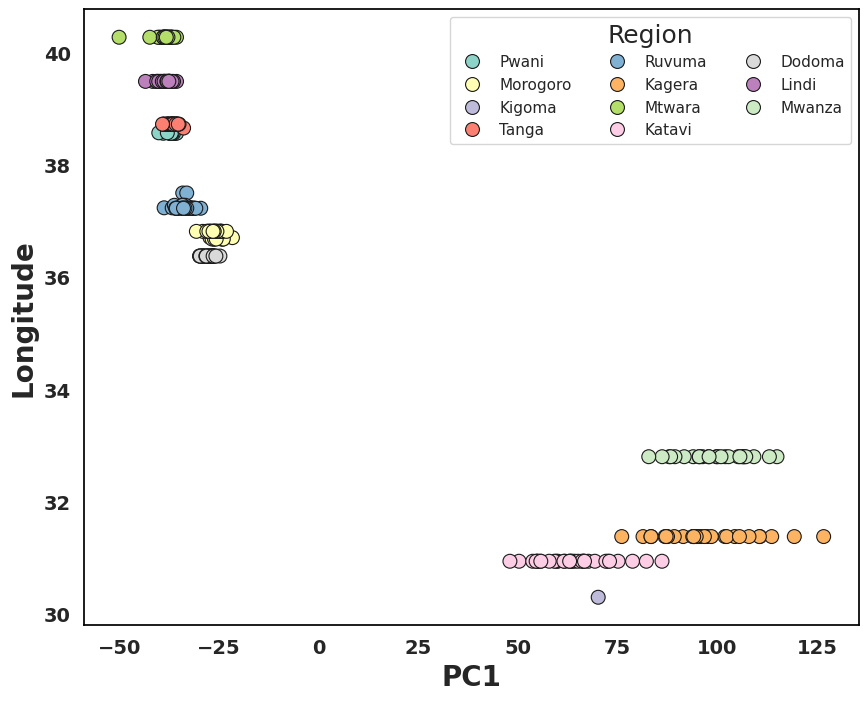

In [30]:
#read output from drive
pca_df = pd.read_csv('drive/MyDrive/tz_funestus_analysis/2rl_pca_df.csv')


# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11)

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    'Kigoma': set3_palette[2],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
sns.set(style='whitegrid')

# Create the PCA plot
plt.figure(figsize=(10, 8))
pca_plot = sns.scatterplot(
    x='PC1', y='longitude',
    hue='admin1_name',
    palette=color_mapping,
    data=pca_df,
    s=100,
    edgecolor='k'
)

# Customize the plot with titles and labels
pca_plot.set_title('', fontsize=15, weight='bold')
pca_plot.set_xlabel('PC1', fontsize=20, weight='bold')
pca_plot.set_ylabel('Longitude', fontsize=20, weight='bold')
pca_plot.legend(title='Region',loc='upper right', bbox_to_anchor=(1, 1), ncol=3, title_fontsize='18')
pca_plot.grid(False)

# Customize the tick labels to be bold
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Add black border to the plot
pca_plot.spines['top'].set_visible(True)
pca_plot.spines['right'].set_visible(True)
pca_plot.spines['left'].set_visible(True)
pca_plot.spines['bottom'].set_visible(True)
pca_plot.spines['top'].set_color('black')
pca_plot.spines['right'].set_color('black')
pca_plot.spines['left'].set_color('black')
pca_plot.spines['bottom'].set_color('black')

# Save the figure with high resolution for publication
plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/2rl_pca_plot.tiff', dpi=350, bbox_inches='tight', format='tiff')
plt.savefig("/content/drive/MyDrive/tz_funestus_analysis/2rl_pca_plot.svg")

# Show the plot
plt.show()

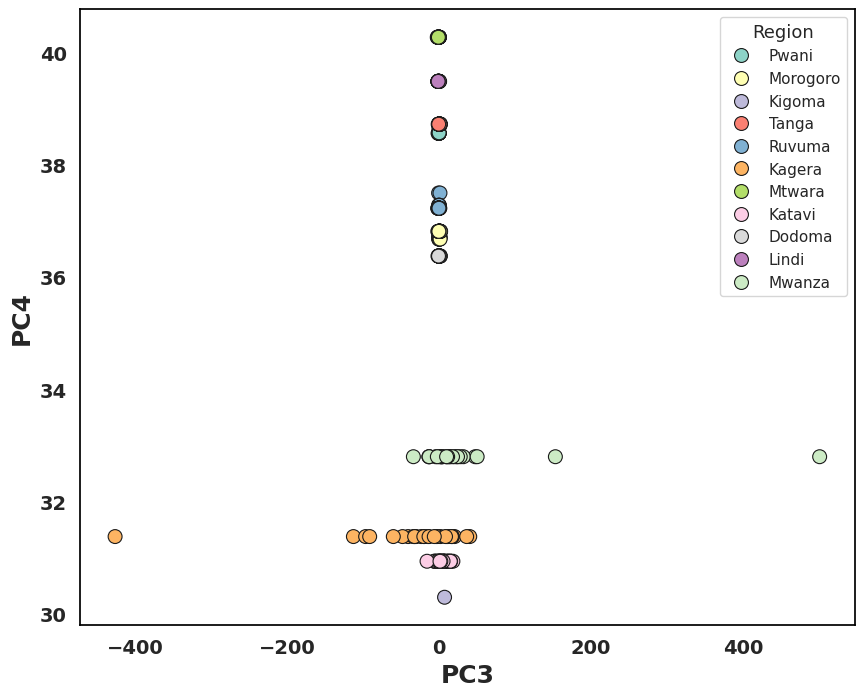

In [31]:
#2rl pc3/pc4
# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11)

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    'Kigoma': set3_palette[2],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
sns.set(style='whitegrid')

# Create the PCA plot
plt.figure(figsize=(10, 8))
pca_plot = sns.scatterplot(
    x='PC3', y='longitude',
    hue='admin1_name',
    palette=color_mapping,
    data=pca_df,
    s=100,
    edgecolor='k'
)

# Customize the plot with titles and labels
pca_plot.set_title('', fontsize=15, weight='bold')
pca_plot.set_xlabel('PC3', fontsize=18, weight='bold')
pca_plot.set_ylabel('PC4', fontsize=18, weight='bold')
pca_plot.legend(title='Region', title_fontsize='13', fontsize='11')
pca_plot.grid(False)

# Customize the tick labels to be bold
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Add black border to the plot
pca_plot.spines['top'].set_visible(True)
pca_plot.spines['right'].set_visible(True)
pca_plot.spines['left'].set_visible(True)
pca_plot.spines['bottom'].set_visible(True)
pca_plot.spines['top'].set_color('black')
pca_plot.spines['right'].set_color('black')
pca_plot.spines['left'].set_color('black')
pca_plot.spines['bottom'].set_color('black')

# Save the figure with high resolution for publication
plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/2rl_pc3_pc4_plot.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

In [ ]:
#by rift location
rift_north = ['Mwanza', 'Kagera', 'Katavi', 'Kigoma']
rift_south = ['Pwani', 'Morogoro', 'Tanga', 'Ruvuma', 'Dodoma', 'Lindi', 'Mtwara']

In [ ]:
pca_rift_north_df, evr = af1.pca(region='2RL: 57,604,655-90,000,000', n_snps=100_000, sample_sets=sample_sets_tz, sample_query = f"sample_id != {samples_ex} & taxon == 'funestus' & admin1_name == {rift_north} ")
#save output in drive
pca_rift_north_df.to_csv('drive/MyDrive/tz_funestus_analysis/pca_rift_north_df.csv')

Compute SNP allele counts:   0%|          | 0/3564 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/4860 [00:00<?, ?it/s]

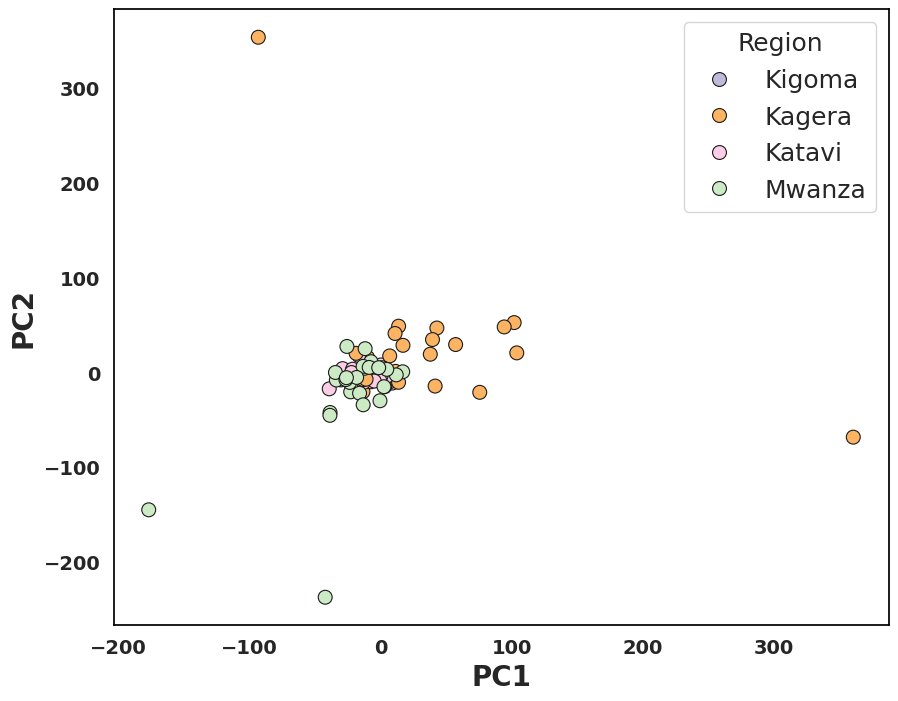

In [32]:
#read output from drive
pca_rift_north_df = pd.read_csv('drive/MyDrive/tz_funestus_analysis/pca_rift_north_df.csv')

# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11)

# Map specific colors to regions
color_mapping = {
    'Kigoma': set3_palette[2],
    'Kagera': set3_palette[5],
    'Katavi': set3_palette[7],
    'Mwanza': set3_palette[10]
}
sns.set(style='whitegrid')

# Create the PCA plot
plt.figure(figsize=(10, 8))
pca_plot = sns.scatterplot(
    x='PC1', y='PC2',
    hue='admin1_name',
    palette=color_mapping,
    data=pca_rift_north_df,
    s=100,
    edgecolor='k'
)

# Customize the plot with titles and labels
pca_plot.set_title('', fontsize=15, weight='bold')
pca_plot.set_xlabel('PC1', fontsize=20, weight='bold')
pca_plot.set_ylabel('PC2', fontsize=20, weight='bold')
pca_plot.legend(title='Region', title_fontsize='18', fontsize='18')
pca_plot.grid(False)

# Customize the tick labels to be bold
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Add black border to the plot
pca_plot.spines['top'].set_visible(True)
pca_plot.spines['right'].set_visible(True)
pca_plot.spines['left'].set_visible(True)
pca_plot.spines['bottom'].set_visible(True)
pca_plot.spines['top'].set_color('black')
pca_plot.spines['right'].set_color('black')
pca_plot.spines['left'].set_color('black')
pca_plot.spines['bottom'].set_color('black')

# Save the figure with high resolution for publication
plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/2rl_rift_north_plot.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

In [ ]:
pca_rift_south_df, evr = af1.pca(region='2RL: 40,604,655-90,000,000', n_snps=100_000, sample_sets=sample_sets_tz, sample_query = f"sample_id != {samples_ex} & taxon == 'funestus' & admin1_name == {rift_south} ")
#save output in drive
pca_rift_south_df.to_csv('drive/MyDrive/tz_funestus_analysis/pca_rift_south_df.csv')

Compute SNP allele counts:   0%|          | 0/6765 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/9405 [00:00<?, ?it/s]

In [ ]:
pca_xdf, evr = af1.pca(region='X', n_snps=100_000, sample_sets=sample_sets_tz, sample_query = f"sample_id != {samples_ex} & taxon == 'funestus'")
#save output in drive
pca_xdf.to_csv('drive/MyDrive/tz_funestus_analysis/pca_xdf.csv')

Compute SNP allele counts:   0%|          | 0/1575 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/2775 [00:00<?, ?it/s]

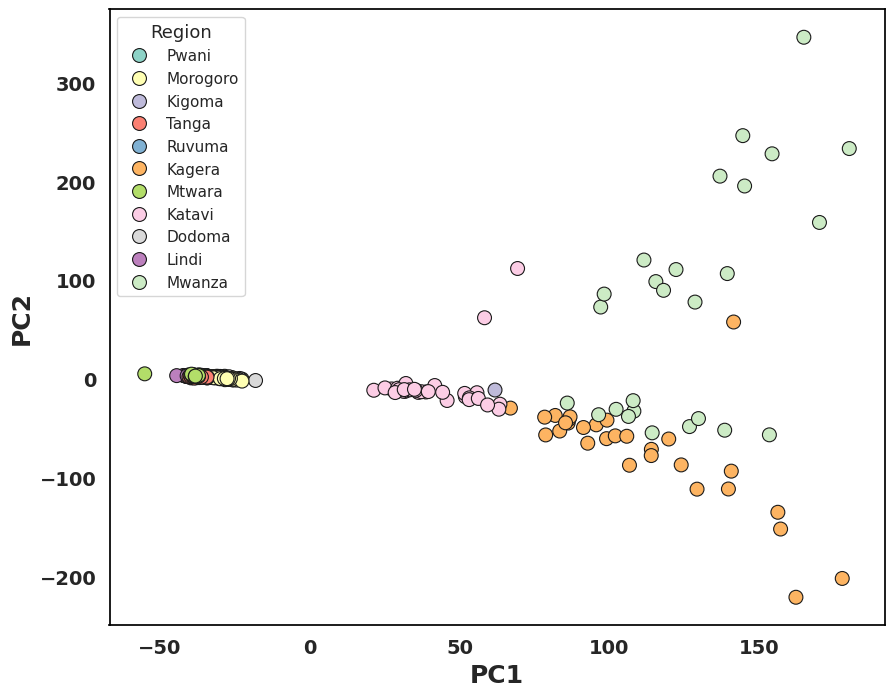

In [35]:
#read output from drive
pca_xdf = pd.read_csv('drive/MyDrive/tz_funestus_analysis/pca_xdf.csv')

# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11)

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    'Kigoma': set3_palette[2],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
sns.set(style='whitegrid')

# Create the PCA plot
plt.figure(figsize=(10, 8))
pca_plot = sns.scatterplot(
    x='PC1', y='PC2',
    hue='admin1_name',
    palette=color_mapping,
    data=pca_xdf,
    s=100,
    edgecolor='k'
)

# Customize the plot with titles and labels
pca_plot.set_title('', fontsize=15, weight='bold')
pca_plot.set_xlabel('PC1', fontsize=18, weight='bold')
pca_plot.set_ylabel('PC2', fontsize=18, weight='bold')
pca_plot.legend(title='Region', title_fontsize='13', fontsize='11')
pca_plot.grid(False)

# Customize the tick labels to be bold
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Add black border to the plot
pca_plot.spines['top'].set_visible(True)
pca_plot.spines['right'].set_visible(True)
pca_plot.spines['left'].set_visible(True)
pca_plot.spines['bottom'].set_visible(True)
pca_plot.spines['top'].set_color('black')
pca_plot.spines['right'].set_color('black')
pca_plot.spines['left'].set_color('black')
pca_plot.spines['bottom'].set_color('black')


# Save the figure with high resolution for publication
plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/x_pca_plot.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

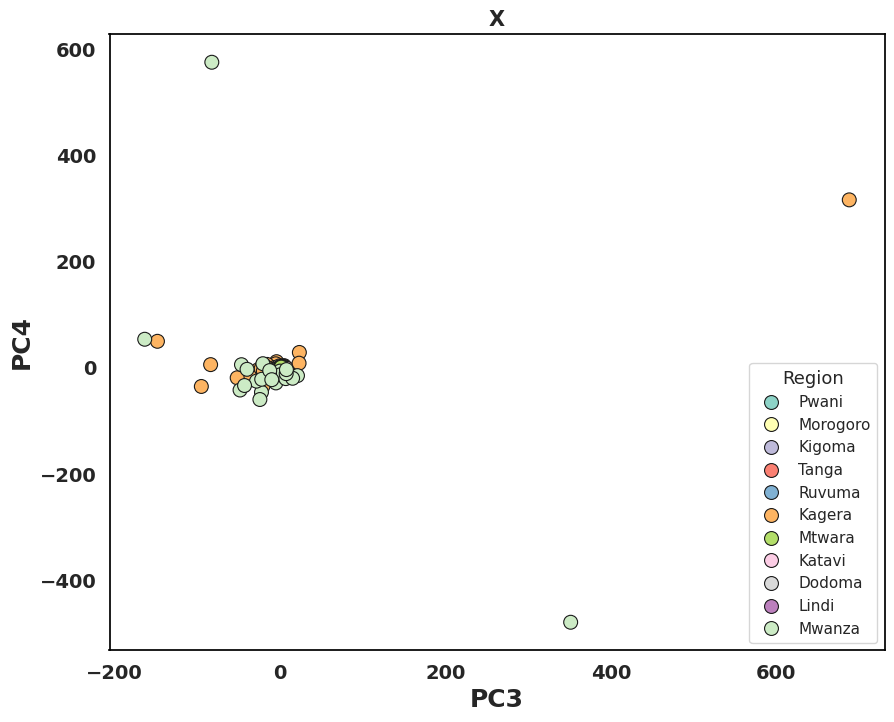

In [36]:
# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11)

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    'Kigoma': set3_palette[2],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
sns.set(style='whitegrid')

# Create the PCA plot
plt.figure(figsize=(10, 8))
pca_plot = sns.scatterplot(
    x='PC3', y='PC4',
    hue='admin1_name',
    palette=color_mapping,
    data=pca_xdf,
    s=100,
    edgecolor='k'
)

# Customize the plot with titles and labels
pca_plot.set_title('X', fontsize=15, weight='bold')
pca_plot.set_xlabel('PC3', fontsize=18, weight='bold')
pca_plot.set_ylabel('PC4', fontsize=18, weight='bold')
pca_plot.legend(title='Region', title_fontsize='13', fontsize='11')
pca_plot.grid(False)

# Customize the tick labels to be bold
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='bold')

# Add black border to the plot
pca_plot.spines['top'].set_visible(True)
pca_plot.spines['right'].set_visible(True)
pca_plot.spines['left'].set_visible(True)
pca_plot.spines['bottom'].set_visible(True)
pca_plot.spines['top'].set_color('black')
pca_plot.spines['right'].set_color('black')
pca_plot.spines['left'].set_color('black')
pca_plot.spines['bottom'].set_color('black')


# Save the figure with high resolution for publication
plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/x_pc3_pc4_plot.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

#diversity stats


In [ ]:
#getting help to know what parameters are needed
af1.diversity_stats?

In [ ]:
#Tanzania diversity stats by admin regions
divstats = af1.diversity_stats(
    sample_sets = (sample_sets_tz),
    sample_query="taxon == 'funestus'",
    cohorts='admin1_name',
    cohort_size=10,
    region='2RL',
    site_mask="funestus",
)
divstats
#save output in drive
divstats.to_csv('drive/MyDrive/tz_funestus_analysis/divstats.csv')

Cohort (Kigoma) has insufficient samples (1) for requested cohort size (10), dropping.


Compute SNP allele counts:   0%|          | 0/2401 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3087 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/2401 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1715 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3087 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4116 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/686 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1715 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1715 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3087 [00:00<?, ?it/s]

In [ ]:
# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11).as_hex()

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
# Create a new column for color based on region
divstats['color'] = divstats['admin1_name'].map(color_mapping)
# Customize parameters
color = 'color'
height = 600
width = 1000
hover_name = 'admin1_name'
hover_data = {'theta_pi_estimate': True, 'theta_pi_ci_err': True}
labels = {
    'admin1_name': '',
    'theta_pi_estimate': "Nucleotide diversity (π)",
    'theta_pi_ci_err': 'Error'
}
template = 'plotly_white'
# Create the bar plot
fig = px.bar(
    data_frame=divstats,
    x="admin1_name",
    y="theta_pi_estimate",
    error_y="theta_pi_ci_err",
    title="A",
    height=height,
    width=width,
    hover_name=hover_name,
    hover_data=hover_data,
    labels=labels,
    template=template,
    category_orders={"admin1_name": ["Kagera", "Mwanza", "Katavi", "Dodoma", 'Morogoro', 'Pwani', 'Ruvuma', 'Tanga', 'Lindi', 'Mtwara']}
)

# Make axis labels bold
fig.update_xaxes(title_font=dict(family="Arial Bold", size=14))
fig.update_yaxes(title_font=dict(family="Arial Bold", size=14))

# Update the colors in the plot
fig.update_traces(marker=dict(color=divstats['color']))

# Export the plot in TIFF format
#fig.write_image("tajima_d_plot.tiff", format="tiff", scale=5)

# Display the plot
fig.show()

In [ ]:
# Get Set3 color palette from seaborn
set3_palette = sns.color_palette("Set3", 11).as_hex()

# Map specific colors to regions
color_mapping = {
    'Pwani': set3_palette[0],
    'Morogoro': set3_palette[1],
    #'Kigoma': set3_palette[2],
    'Tanga': set3_palette[3],
    'Ruvuma': set3_palette[4],
    'Kagera': set3_palette[5],
    'Mtwara': set3_palette[6],
    'Katavi': set3_palette[7],
    'Dodoma': set3_palette[8],
    'Lindi': set3_palette[9],
    'Mwanza': set3_palette[10]
}
# Create a new column for color based on region
divstats['color'] = divstats['admin1_name'].map(color_mapping)
# Customize parameters
color = 'color'
height = 600
width = 1000
hover_name = 'admin1_name'
hover_data = {'tajima_d_estimate': True, 'tajima_d_ci_err': True}
labels = {
    'admin1_name': '',
    'tajima_d_estimate': "Tajima's D",
    'tajima_d_ci_err': 'Error'
}
template = 'plotly_white'
# Create the bar plot
fig = px.bar(
    data_frame=divstats,
    x="admin1_name",
    y="tajima_d_estimate",
    error_y="tajima_d_ci_err",
    title="B",
    height=height,
    width=width,
    hover_name=hover_name,
    hover_data=hover_data,
    labels=labels,
    template=template,
    category_orders={"admin1_name": ["Kagera", "Mwanza", "Katavi", "Dodoma", 'Morogoro', 'Pwani', 'Ruvuma', 'Tanga', 'Lindi', 'Mtwara']}
)

# Make axis labels bold
fig.update_xaxes(title_font=dict(family="Arial Bold", size=16))
fig.update_yaxes(title_font=dict(family="Arial Bold", size=16))

# Update the colors in the plot
fig.update_traces(marker=dict(color=divstats['color']))
#fig.grid(False)

# Save the figure with high resolution for publication
#plt.savefig('/content/drive/MyDrive/tz_funestus_analysis/tajd_plot.png', dpi=300, bbox_inches='tight', format='png')


# Display the plot
fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio


In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

In [ ]:
#Fst between cohorts grouped based on 2rl PCA

import itertools as it
chroms = ['2RL','3RL','X']
locs = ['Mwanza', 'Kagera', 'Katavi', 'Pwani', 'Morogoro', 'Tanga', 'Ruvuma', 'Dodoma', 'Lindi', 'Mtwara']

#dict of  analysis groupings based on 2rl PCA
loc_dict = {'Inland' : 'admin1_name == "Katavi" | admin1_name == "Mwanza" | admin1_name == "Kagera"| admin1_name == "Kigoma"',
            'Coastal A' :  'admin1_name == "Tanga"',
            'Coastal B' : 'admin1_name == "Morogoro" | admin1_name == "Pwani"| admin1_name == "Dodoma"',
            'Coastal C' : ' admin1_name == "Ruvuma" | admin1_name == "Lindi" | admin1_name == "Mtwara"'}
cohort_labels = ['Inland', 'Coastal A', 'Coastal B', 'Coastal C']


fst_df_list = []
for a,b in it.combinations(cohort_labels,2):
    for chrom in chroms:
      fstar = af1.fst_gwss(contig = chrom, min_cohort_size=10, window_size=5000, cohort1_query=loc_dict[f'{a}'], cohort2_query=loc_dict[f'{b}'])
      fst_df = pd.DataFrame({'pos':fstar[0], 'fst':fstar[1]})
      fst_df['chrom'] = chrom
      fst_df['location_a'] = a
      fst_df['location_b'] = b
      fst_df_list.append(fst_df)


fst_bigdf = pd.concat(fst_df_list)

fst_bigdf.to_csv('drive/MyDrive/tz_funestus_analysis/fstdf.csv')


Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4116 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3396 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/900 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/6517 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5377 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1425 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4116 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/6517 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3396 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5377 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/900 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1425 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4116 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/3396 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/900 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/6517 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5831 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/5377 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/4811 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1425 [00:00<?, ?it/s]

Compute SNP allele counts:   0%|          | 0/1275 [00:00<?, ?it/s]

In [ ]:
fst_bigdf

,pos,fst,chrom,location_a,location_b
0,8.409830e+04,0.031005,2RL,Inland,Coastal A
1,9.177232e+04,0.044782,2RL,Inland,Coastal A
2,9.844864e+04,0.042077,2RL,Inland,Coastal A
3,1.090800e+05,0.073308,2RL,Inland,Coastal A
4,1.186032e+05,0.063254,2RL,Inland,Coastal A
...,...,...,...,...,...
2013,2.143679e+07,0.000000,X,Coastal B,Coastal C
2014,2.162824e+07,0.003631,X,Coastal B,Coastal C
2015,2.173876e+07,0.002174,X,Coastal B,Coastal C
2016,2.187121e+07,0.000000,X,Coastal B,Coastal C


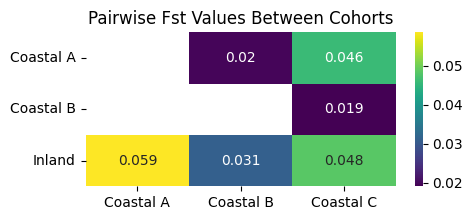

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data (if not already loaded)
fst_bigdf = pd.read_csv('drive/MyDrive/tz_funestus_analysis/fstdf.csv')

# Calculate the mean Fst value for each pair of cohorts and chromosomes
fst_pivot = fst_bigdf.groupby(['location_a', 'location_b', 'chrom'])['fst'].mean().reset_index()

# Pivot the DataFrame to create a matrix suitable for a heatmap
fst_matrix = fst_pivot.pivot_table(index='location_a', columns='location_b', values='fst')

# Plot the heatmap
plt.figure(figsize=(5, 2))
sns.heatmap(fst_matrix, annot=True, cmap='viridis', cbar=True)
plt.title('Pairwise Fst Values Between Cohorts')
plt.xlabel('')
plt.ylabel('')
plt.show()

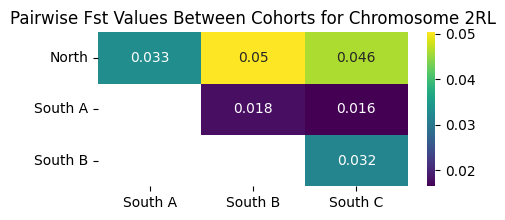

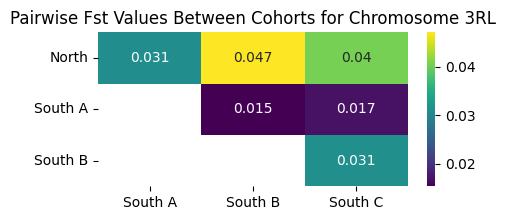

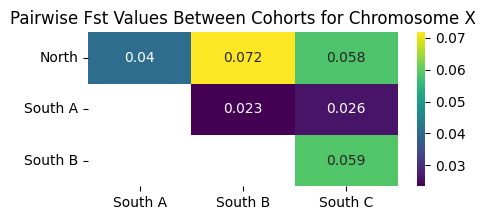

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data (if not already loaded)
fst_bigdf = pd.read_csv('drive/MyDrive/tz_funestus_analysis/fstdf_2.csv')

# Loop through each chromosome and create a heatmap
chroms = ['2RL', '3RL', 'X']
for chrom in chroms:
    # Filter the DataFrame for the current chromosome
    chrom_df = fst_bigdf[fst_bigdf['chrom'] == chrom]

    # Calculate the mean Fst value for each pair of cohorts
    fst_pivot = chrom_df.groupby(['location_a', 'location_b'])['fst'].mean().reset_index()

    # Pivot the DataFrame to create a matrix suitable for a heatmap
    fst_matrix = fst_pivot.pivot_table(index='location_a', columns='location_b', values='fst')

    # Plot the heatmap
    plt.figure(figsize=(5, 2))
    sns.heatmap(fst_matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(f'Pairwise Fst Values Between Cohorts for Chromosome {chrom}')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [ ]:
#read from drive
fst_bigdf = pd.read_csv('drive/MyDrive/tz_funestus_analysis/fstdf.csv')
#bind and add loc:loc factor for plotting
fst_bigdf['comp'] = fst_bigdf["location_a"] +'-'+ fst_bigdf["location_b"]

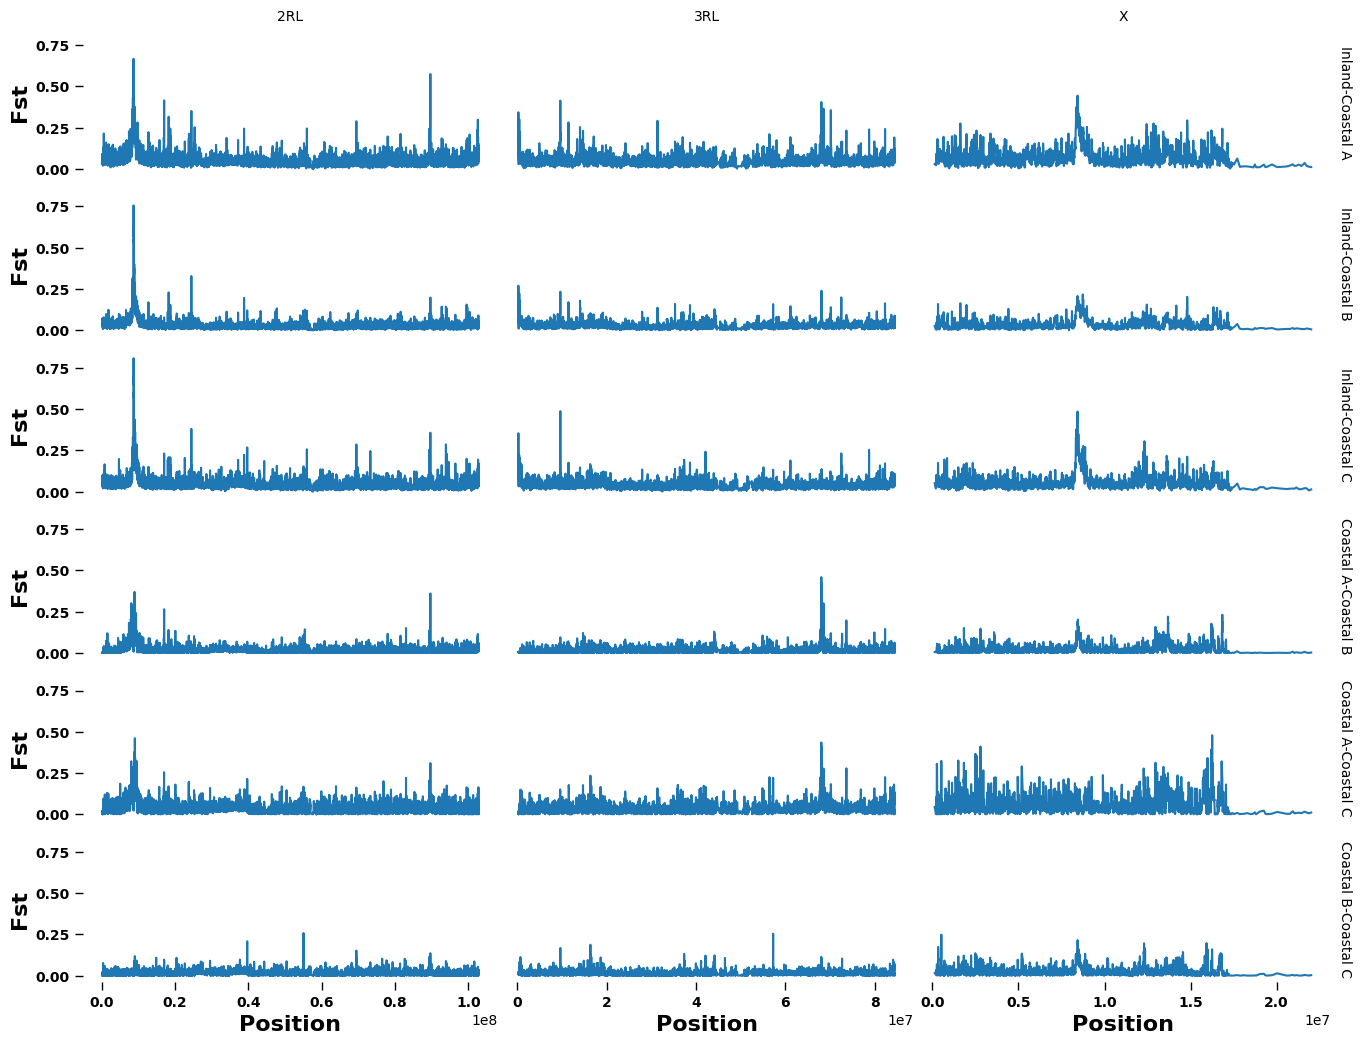

In [ ]:
# import DataFrame containing the data
plt_fst = sns.FacetGrid(fst_bigdf,
                        row="comp",
                        col="chrom",
                        height=1.8, aspect=2.5,
                        sharex=False,
                        sharey=True,
                        margin_titles=True)
plt_fst.map(sns.lineplot, "pos", "fst")
plt_fst.despine(left=True, bottom=True)
plt_fst.set_titles(col_template="{col_name}", row_template="{row_name}")

# Adjust subplot spacing
plt_fst.fig.subplots_adjust(wspace=0.005, hspace=0.1)

# Set axis labels
plt_fst.set_axis_labels("Position", "Fst", fontsize=16, fontweight='bold')

# Bold tick labels for each axis
for ax in plt_fst.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=14, width=1, direction='out', length=6)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontsize(10)
        tick.set_fontweight('bold')

# Remove y-axis ticks from columns except the first column
for axis in plt_fst.axes[:, 1:].flatten():
    axis.tick_params(left=False)

# Remove x-axis ticks from rows except the bottom row
for axis in plt_fst.axes[:-1, :].flatten():
    axis.tick_params(bottom=False, labelbottom=False)

# Disable grid lines for each axis
for ax in plt_fst.axes.flatten():
    ax.grid(False)  # This turns off the grid for each subplot

# Set custom y-axis ticks
for ax in plt_fst.axes.flatten():
    ax.set_yticks([0.00, 0.25, 0.50, 0.75])

plt_fst.fig.text(0.01, 0.99, '', fontsize=16, fontweight='bold', ha='center', va='center', transform=plt_fst.fig.transFigure)
# Save plot as TIFF
plt_fst.fig.savefig('/content/drive/MyDrive/tz_funestus_analysis/plt_fst.tiff', format='tiff', dpi=300, bbox_inches='tight')
# Save plot as png
plt_fst.fig.savefig('/content/drive/MyDrive/tz_funestus_analysis/plt_fst.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [ ]:
#GWSS with H12
import itertools as it

chroms = ['2RL', '3RL', 'X']
locs = ['Mwanza', 'Kagera', 'Katavi', 'Pwani', 'Morogoro', 'Tanga', 'Ruvuma', 'Dodoma', 'Lindi', 'Mtwara']


#dict of  analysis groupings based on 2rl PCA
loc_dict = {'Inland' : 'admin1_name == "Katavi" | admin1_name == "Mwanza" | admin1_name == "Kagera"| admin1_name == "Kigoma"',
            'Coastal A' :  'admin1_name == "Tanga"',
            'Coastal B' : 'admin1_name == "Morogoro" | admin1_name == "Pwani"| admin1_name == "Dodoma"',
            'Coastal C' : ' admin1_name == "Ruvuma" | admin1_name == "Lindi" | admin1_name == "Mtwara"'}
cohort_labels = ['Inland', 'Coastal A', 'Coastal B', 'Coastal C']


h_list = []

for chrom in chroms:
    for pop_lab in loc_dict.keys():
        h12ar = af1.h12_gwss(contig=chrom, sample_query=loc_dict[pop_lab], window_size=2000, min_cohort_size=10)
        h12_df = pd.DataFrame({'pos': h12ar[0], 'h12': h12ar[1]})
        h12_df['chrom'] = chrom
        h12_df['location'] = pop_lab
        h_list.append(h12_df)

h12_bigdf = pd.concat(h_list)
#save to drive
h12_bigdf.to_csv("drive/MyDrive/tz_funestus_analysis/h12_tz.csv")

Load haplotypes:   0%|          | 0/1106 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/632 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/1106 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/948 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/854 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/488 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/854 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/732 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/196 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/112 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/196 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/168 [00:00<?, ?it/s]

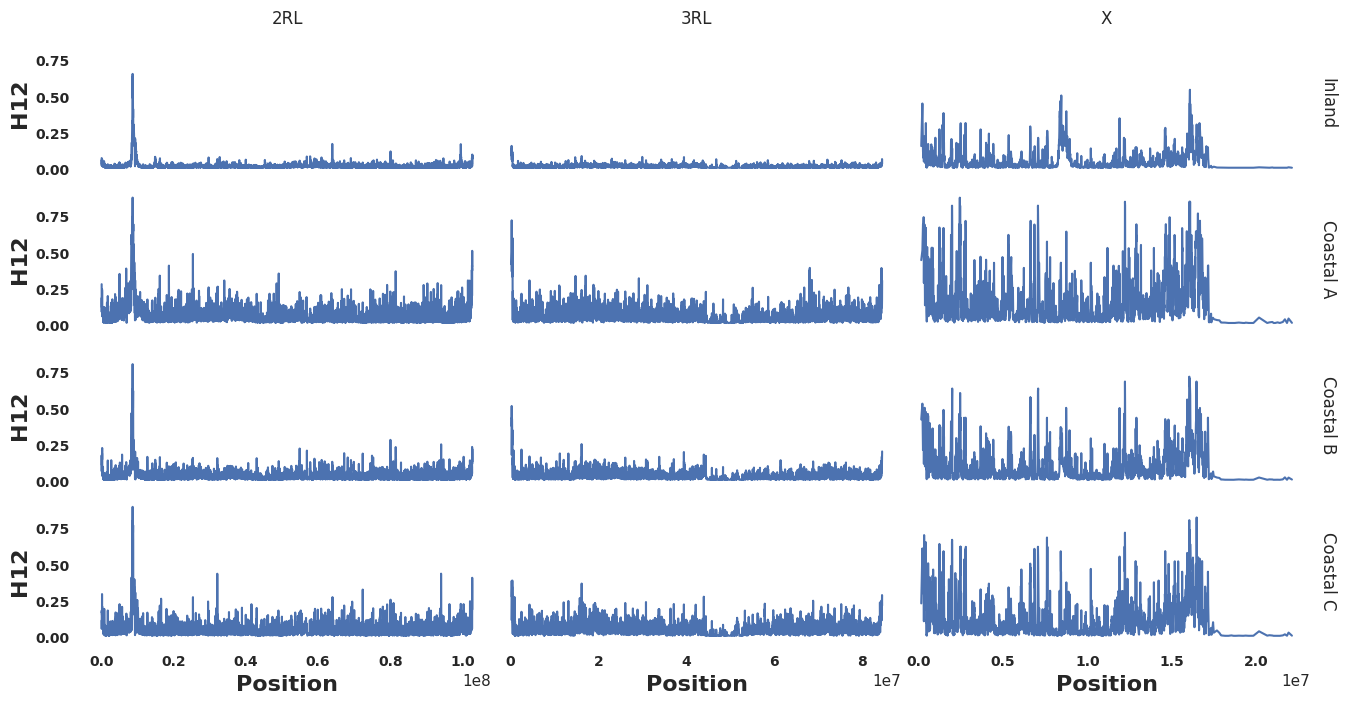

In [ ]:
#load from drive
df_h = pd.read_csv("drive/MyDrive/tz_funestus_analysis/h12_tz.csv")

# Set the style to white and remove grids
sns.set(style="white", rc={"axes.grid": False})

#plot H12 GWSS
# Create a FacetGrid with rows based on 'location' and columns based on 'chrom'
plt_h = sns.FacetGrid(df_h,
                            row="location",
                            col="chrom",
                            height=1.8, aspect=2.5,
                            sharex=False,
                            sharey=True,
                            margin_titles=True)
# Map lineplot onto the grid using 'pos' as x-axis and 'h12' as y-axis
plt_h.map(sns.lineplot, "pos", "h12")
# Remove spines from left and bottom of each subplot
plt_h.despine(left=True, bottom=True)
# Set titles for columns and rows
plt_h.set_titles(col_template="{col_name}", row_template="{row_name}")
#plt.subplots_adjust(wspace=0.005)
plt_h.fig.subplots_adjust(wspace=0.005, hspace=0.1)

# Set axis labels
plt_h.set_axis_labels("Position", "H12", fontsize=16, fontweight='bold')

# Bold tick labels for each axis
for ax in plt_h.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=14, width=1, direction='out', length=6)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontsize(10)
        tick.set_fontweight('bold')


#remove y axis ticks from cols 3rl and x
for axis in plt_h.axes[:,1:].flatten():
    axis.tick_params(left=False)

#remove x axis ticks from rows except bottom
for axis in plt_h.axes[:-1, :].flatten():
    axis.tick_params(bottom=False, labelbottom=False)

# Set custom y-axis ticks
for ax in plt_h.axes.flatten():
    ax.set_yticks([0.00, 0.25, 0.50, 0.75])

plt_h.fig.text(0.01, 0.99, '', fontsize=16, fontweight='bold', ha='center', va='center', transform=plt_h.fig.transFigure)

plt_h.savefig("drive/MyDrive/tz_funestus_analysis/h12_tz.svg")
# Save plot as TIFF
plt_h.fig.savefig('/content/drive/MyDrive/tz_funestus_analysis/h12_tz.tiff', format='tiff', dpi=300, bbox_inches='tight')
# Save plot as png
plt_h.fig.savefig('/content/drive/MyDrive/tz_funestus_analysis/h12_tz.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [ ]:
#Allele frequencies
afdf = af1.aa_allele_frequencies(
    transcript='LOC125764232_t1',
    sample_sets=sample_sets_tz,
    min_cohort_size= 5,
    cohorts='cohort_admin1_year',
    sample_query="country== 'Tanzania'",
    drop_invariant = True
)
minmaf = 0.05
afdf = afdf[afdf['effect'] == 'NON_SYNONYMOUS_CODING']
afdf = afdf[afdf['max_af'] > minmaf]
afdf['Transcript'] = 'LOC125764232_t1'

Load SNP genotypes:   0%|          | 0/18 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/14 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
feat = af1.genome_features(region='2RL:8671966-8705938')
feat = feat.query('type == "protein_coding_gene"')
tids = feat['ID'].tolist() + ['LOC125764232'] #add cyp9k1

In [ ]:

#make big table of IR allele freqs
def prep_af_df(tsc, minmaf):
  afdf = af1.aa_allele_frequencies(
      transcript=f"{tsc}_t1",
      min_cohort_size= 5,
      sample_sets=sample_sets_tz,
      cohorts='cohort_admin1_year',
      sample_query="country== 'Tanzania'",
      drop_invariant = True
  )
  afdf = afdf[afdf['effect'] == 'NON_SYNONYMOUS_CODING']
  afdf = afdf[afdf['max_af'] > minmaf]
  afdf['Transcript'] = tsc
  return(afdf)

afdfs = []
for t in tids:
  d = prep_af_df(t, 0.05)
  afdfs.append(d)

In [ ]:
t = pd.concat(afdfs)
t
t.to_csv("drive/MyDrive/tz_funestus_analysis/aa_frequencies_tz.csv")

In [65]:
Cyp9k1 = af1.snp_allele_frequencies(
    transcript='LOC125764232_t1',
    min_cohort_size= 5,
    sample_sets=sample_sets_tz,
    cohorts="cohort_admin1_year",
    sample_query="country== 'Tanzania'",
)
Cyp9k1

Load SNP genotypes:   0%|          | 0/18 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/14 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/256 [00:00<?, ?it/s]

pass_funestus  \
contig position ref_allele alt_allele aa_change                  
X      8448485  A          G          NaN                 True   
       8448507  G          A          NaN                 True   
       8448516  G          T          NaN                 True   
       8448566  C          T          NaN                 True   
       8448572  T          G          NaN                 True   
...                                                        ...   
       8450837  T          C          NaN                False   
       8450838  T          C          NaN                False   
       8450842  T          G          NaN                 True   
       8450845  T          G          NaN                False   
       8450852  C          T          NaN                 True   

                                                 frq_TZ-03_fune_2022  \
contig position ref_allele alt_allele aa_change                        
X      8448485  A          G          NaN                   0.000000   
       8448507  G          A          NaN                   0.000000   
       8448516  G          T          NaN                   0.000000   
       8448566  C          T          NaN                   0.000000   
       8448572  T          G          NaN                   0.000000   
...                                                              ...   
       8450837  T          C          NaN                   0.000000   
       8450838  T          C          NaN                   0.000000   
       8450842  T          G          NaN                   0.000000   
       8450845  T          G          NaN                   0.000000   
       8450852  C          T          NaN                   0.607143   

                                                 frq_TZ-05_fune_2022  \
contig position ref_allele alt_allele aa_change                        
X      8448485  A          G          NaN                   0.015625   
       8448507  G          A          NaN                   0.000000   
       8448516  G          T          NaN                   0.000000   
       8448566  C          T          NaN                   0.015625   
       8448572  T          G          NaN                   0.015625   
...                                                              ...   
       8450837  T          C          NaN                        NaN   
       8450838  T          C          NaN                        NaN   
       8450842  T          G          NaN                   0.015625   
       8450845  T          G          NaN                   0.000000   
       8450852  C          T          NaN                   0.015625   

                                                 frq_TZ-12_fune_2022  \
contig position ref_allele alt_allele aa_change                        
X      8448485  A          G          NaN                   0.000000   
       8448507  G          A          NaN                   0.000000   
       8448516  G          T          NaN                   0.000000   
       8448566  C          T          NaN                   0.000000   
       8448572  T          G          NaN                   0.000000   
...                                                              ...   
       8450837  T          C          NaN                   0.045455   
       8450838  T          C          NaN                   0.103448   
       8450842  T          G          NaN                   0.000000   
       8450845  T          G          NaN                   0.016667   
       8450852  C          T          NaN                   0.350000   

                                                 frq_TZ-16_fune_2017  \
contig position ref_allele alt_allele aa_change                        
X      8448485  A          G          NaN                   0.000000   
       8448507  G          A          NaN                   0.000000   
       8448516  G          T          NaN                   0.000000   
       8448566  C  

In [66]:
Cyp9k1 = Cyp9k1.query("effect == 'NON_SYNONYMOUS_CODING' and max_af > 0.05")
Cyp9k1
Cyp9k1.to_csv("drive/MyDrive/tz_funestus_analysis/Cyp9k1_aa_frequencies_tz.csv")

In [67]:
af1.plot_frequencies_heatmap(Cyp9k1, title= "Cyp9k1")

In [68]:
Cyp6p9a = af1.snp_allele_frequencies(
    transcript='LOC125764713_t1',
    min_cohort_size= 5,
    sample_sets=sample_sets_tz,
    cohorts="cohort_admin1_year",
    sample_query="country== 'Tanzania'",
)
Cyp6p9a

Load SNP genotypes:   0%|          | 0/18 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/14 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/710 [00:00<?, ?it/s]

pass_funestus  \
contig position ref_allele alt_allele aa_change                  
2RL    8685469  T          A          NaN                 True   
       8685485  C          T          NaN                 True   
       8685498  C          T          NaN                 True   
       8685503  T          G          NaN                False   
       8685504  T          C          NaN                 True   
...                                                        ...   
       8690302  T          C          A17A               False   
       8690304  C          G          A17P                True   
       8690327  G          A          A9V                 True   
       8690371  A          C          NaN                False   
       8690395  A          G          NaN                False   

                                                 frq_TZ-03_fune_2022  \
contig position ref_allele alt_allele aa_change                        
2RL    8685469  T          A          NaN                   0.000000   
       8685485  C          T          NaN                   0.000000   
       8685498  C          T          NaN                   1.000000   
       8685503  T          G          NaN                   1.000000   
       8685504  T          C          NaN                   0.017857   
...                                                              ...   
       8690302  T          C          A17A                  0.000000   
       8690304  C          G          A17P                  0.000000   
       8690327  G          A          A9V                   0.000000   
       8690371  A          C          NaN                   0.107143   
       8690395  A          G          NaN                   0.000000   

                                                 frq_TZ-05_fune_2022  \
contig position ref_allele alt_allele aa_change                        
2RL    8685469  T          A          NaN                   0.984375   
       8685485  C          T          NaN                   0.000000   
       8685498  C          T          NaN                   0.015625   
       8685503  T          G          NaN                   0.015625   
       8685504  T          C          NaN                   0.000000   
...                                                              ...   
       8690302  T          C          A17A                  0.000000   
       8690304  C          G          A17P                  0.000000   
       8690327  G          A          A9V                   0.000000   
       8690371  A          C          NaN                   0.000000   
       8690395  A          G          NaN                   0.000000   

                                                 frq_TZ-12_fune_2022  \
contig position ref_allele alt_allele aa_change                        
2RL    8685469  T          A          NaN                   0.050000   
       8685485  C          T          NaN                   0.000000   
       8685498  C          T          NaN                   0.950000   
       8685503  T          G          NaN                   0.950000   
       8685504  T          C          NaN                   0.000000   
...                                                              ...   
       8690302  T          C          A17A                  0.000000   
       8690304  C          G          A17P                  0.000000   
       8690327  G          A          A9V                   0.000000   
       8690371  A          C          NaN                   0.400000   
       8690395  A          G          NaN                   0.016667   

                                                 frq_TZ-16_fune_2017  \
contig position ref_allele alt_allele aa_change                        
2RL    8685469  T          A          NaN                       0.00   
       8685485  C          T          NaN                       0.00   
       8685498  C          T          NaN                       1.00   
       8685503  T  

In [69]:
Cyp6p9a = Cyp6p9a.query("effect == 'NON_SYNONYMOUS_CODING' and max_af > 0.05")
Cyp6p9a
Cyp6p9a.to_csv("drive/MyDrive/tz_funestus_analysis/Cyp6p9a_aa_frequencies_tz.csv")

In [71]:
af1.plot_frequencies_heatmap(Cyp6p9a, title= "Cyp6p9a")

In [56]:
#Haplotype clustering
from scipy.spatial.distance import squareform
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch

#define some clustering and plotting functions
#get dist
import numba
def pdist_abs_hamming(X):
    n_obs = X.shape[0]
    n_ftr = X.shape[1]
    out = np.zeros((n_obs, n_obs), dtype=np.int32)
    for i in range(n_obs):
        x = X[i]
        for j in numba.prange(i + 1, n_obs):
            y = X[j]
            d = 0
            for k in range(n_ftr):
                if x[k] != y[k]:
                    d += 1
            out[i, j] = d
            out[j, i] = d
    return out

def plot_dendrogram(h, ax, df_samples):

    #Helper vars I am not fussed about
    color_threshold=0
    above_threshold_color='k'
    linkage_method = 'single'
    distance_sort=True
    count_sort=True

    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # Hierarchical clustering.
    Z = sch.linkage(dist, method=linkage_method)

        #harmonise metadata with samples
    # Align sample metadata with haplotypes.

    # Repeat the dataframe so there is one row of metadata for each haplotype.
    leaf_data = pd.DataFrame(np.repeat(df_samples.values, 2, axis=0))
    leaf_data.columns = df_samples.columns

    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    # Compute the dendrogram but don't plot it.
    dend = sch.dendrogram(
        Z,
        count_sort=count_sort,
        distance_sort=distance_sort,
        no_plot=False,
        color_threshold=color_threshold,
        above_threshold_color=above_threshold_color,
    )

    ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.despine(ax=None, fig=None, offset=5, left=True, bottom=True, top=True, right=True)
    ax.set_ylim(bottom=-2)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)

    return Z, dend, leaf_data

def fig_hap_structure(h, df_samples=tz_sample_df, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(8, 3),
                      fn=None, dpi=150, height_ratios=(0.6, .1), hap_pops=None, legend=True, title=None):
  if legend:
    handles = [mpl.patches.Patch(color=color_mapping[pop], label=pop) for pop in color_mapping.keys()]
    ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3, title="Regions")


    # create the figure
    fig = plt.figure(figsize=figsize)

    # define subplot layout
    gs_nrows = 2
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)

    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r, leafdata = plot_dendrogram(h, ax_dend, df_samples)
    ax_dend.set_ylim(bottom=-5)
    if legend:
        handles = [mpl.patches.Patch(color=color_mapping[pop], label=pop) for pop in color_mapping.keys()]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.set(xticklabels=[])
    ax_dend.set_title(title,fontdict={'fontsize':18}, loc='right')

    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)



    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = leafdata.admin1_name.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [color_mapping[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=2, left=True, bottom=True, top=True, right=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    #ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')
    fig.savefig(f'drive/MyDrive/tz_funestus_analysis/{title}.svg')
    fig.savefig(f'drive/MyDrive/tz_funestus_analysis/{title}.png')

In [62]:
def fig_hap_structure(h, df_samples=tz_sample_df, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(8, 3),
                      fn=None, dpi=150, height_ratios=(0.6, .1), hap_pops=None, legend=True, title=None):

    # create the figure
    fig = plt.figure(figsize=figsize)

    # define subplot layout
    gs_nrows = 2
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)

    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r, leafdata = plot_dendrogram(h, ax_dend, df_samples)
    ax_dend.set_ylim(bottom=-5)
    if legend:
        handles = [mpl.patches.Patch(color=color_mapping[pop], label=pop) for pop in color_mapping.keys()]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3, title="Regions")
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.set(xticklabels=[])
    ax_dend.set_title(title, fontdict={'fontsize': 18}, loc='right')

    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = leafdata.admin1_name.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [color_mapping[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs)
    sns.despine(ax=ax_pops, offset=2, left=True, bottom=True, top=True, right=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # Save the figure
    fig.savefig(f'drive/MyDrive/tz_funestus_analysis/{title}.svg')
    fig.savefig(f'drive/MyDrive/tz_funestus_analysis/{title}.png')


<ipython-input-62-2dd60bf930d4>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


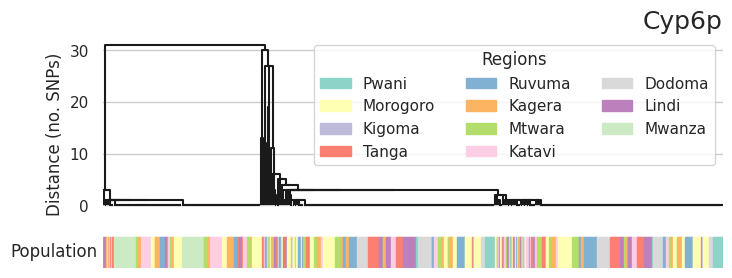

In [63]:
cyp6p9_haps = af1.haplotypes(region="2RL:8,685,464-8,690,407", sample_sets=sample_sets_tz, sample_query="taxon == 'funestus'")
cyp6p9_haps = cyp6p9_haps.call_genotype.compute()
cyp6p9_haps = allel.GenotypeArray(cyp6p9_haps).to_haplotypes()
fig_hap_structure(h=cyp6p9_haps, df_samples=tz_sample_df, title='Cyp6p')


<ipython-input-62-2dd60bf930d4>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))


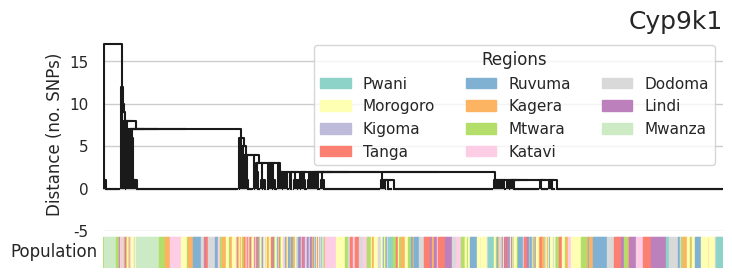

In [64]:
cyp9k1_haps = af1.haplotypes(region="X:8,339,269 - 8,341,975", sample_sets=sample_sets_tz, sample_query="taxon == 'funestus'")
cyp9k1_haps = cyp9k1_haps.call_genotype.compute()
cyp9k1_haps = allel.GenotypeArray(cyp9k1_haps).to_haplotypes()
fig_hap_structure(h=cyp9k1_haps, df_samples=tz_sample_df, title='Cyp9k1')

In [72]:
#CNV
cnv_cyp6p=af1.gene_cnv_frequencies(
    region="2RL:8660000 - 8720000",
    min_cohort_size= 5,
    sample_sets=sample_sets_tz,
    cohorts="cohort_admin1_year",
    sample_query="taxon == 'funestus'"
                                 )
cnv_cyp6p
cnv_cyp6p.to_csv("drive/MyDrive/tz_funestus_analysis/cnv_cyp6p.csv")

Load CNV HMM data:   0%|          | 0/71 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/12 [00:00<?, ?it/s]

In [73]:
af1.plot_frequencies_heatmap(cnv_cyp6p, title= "Cyp6p")

In [74]:
cnv_cy9k1=af1.gene_cnv_frequencies(
    region= "X:8,339,269 - 8,441,975",
    min_cohort_size= 5,
    sample_sets=sample_sets_tz,
    cohorts="cohort_admin1_year",
    sample_query="taxon == 'funestus'"
    )
cnv_cy9k1.to_csv("drive/MyDrive/tz_funestus_analysis/cnv_cy9k1.csv")

Load CNV HMM data:   0%|          | 0/71 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/14 [00:00<?, ?it/s]

In [75]:
af1.plot_frequencies_heatmap(cnv_cy9k1, title= "")